# Time series project

In [3]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [5]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [6]:
import warnings
warnings.filterwarnings('ignore')

### Step 1. Reading the data set

In [7]:
# Load data
data = pd.read_csv('Aquifer_Petrignano.csv')

### Step 2. Exploration and data cleaning

In [8]:
# Obtain dimensions
data.shape

(5223, 8)

In [9]:
# Obtain information about data types and non-null values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB
None


In [10]:
# Visualize the NaN values
data.isnull().sum().sort_values(ascending=False)

Rainfall_Bastia_Umbra                   1024
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Hydrometry_Fiume_Chiascio_Petrignano    1024
Volume_C10_Petrignano                    198
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Date                                       0
dtype: int64

In [11]:
# Delete the NaN values from the DataFrame
data_dropped=data.dropna().reset_index(drop=True)

In [12]:
data_c=data_dropped.copy()
data_c.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.96,-31.14,5.2,4.9,-24530.688,2.4
1,02/01/2009,0.0,-32.03,-31.11,2.3,2.5,-28785.888,2.5
2,03/01/2009,0.0,-31.97,-31.07,4.4,3.9,-25766.208,2.4
3,04/01/2009,0.0,-31.91,-31.05,0.8,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.94,-31.01,-1.9,-2.1,-29854.656,2.3


In [13]:
# Combine the columns with the same features
data_c['Depth_to_Groundwater']=round(((data_c['Depth_to_Groundwater_P24'] + data_c['Depth_to_Groundwater_P25'])/(2)),2)
data_c['Temperature']=round(((data_c['Temperature_Bastia_Umbra'] + data_c['Temperature_Petrignano'])/(2)),2)

In [14]:
# Remove not useful columns
data_c = data_c.drop(columns=['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra', 'Temperature_Petrignano'])

In [15]:
# Simplify column names
data_c.columns= ['Date', 'Rainfall', 'Volume',	'Hydrometry',	'Depth_to_Groundwater',	'Temperature']

In [16]:
# Ordering the columns of the DataFrame
data_c=data_c.reindex(['Date', 'Rainfall',	'Temperature', 'Hydrometry', 'Volume', 'Depth_to_Groundwater'], axis=1)
data_c.head()

,Date,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
0,01/01/2009,0.0,5.05,2.4,-24530.688,-31.55
1,02/01/2009,0.0,2.40,2.5,-28785.888,-31.57
2,03/01/2009,0.0,4.15,2.4,-25766.208,-31.52
3,04/01/2009,0.0,0.80,2.4,-27919.296,-31.48
4,05/01/2009,0.0,-2.00,2.3,-29854.656,-31.48


In [36]:
ts = data_c[['Date', 'Depth_to_Groundwater']]

In [37]:
# Changing the format to the 'Date' column
ts['Date'] = pd.to_datetime(ts['Date'], format = '%d/%m/%Y')
ts = ts.set_index('Date')
ts.head()

,Depth_to_Groundwater
Date,
2009-01-01,-31.55
2009-01-02,-31.57
2009-01-03,-31.52
2009-01-04,-31.48
2009-01-05,-31.48


In [38]:
initial_date = ts.index[0]
final_date   = ts.index[-1]
print(f'Initial date: {initial_date}')
print(f'Final date  : {final_date}')

Initial date: 2009-01-01 00:00:00
Final date  : 2020-06-30 00:00:00


In [39]:
ts.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=4150, freq=None)

In [40]:
ts = ts.asfreq("D")
ts.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=4199, freq='D')

In [41]:
ts['Depth_to_Groundwater'] = ts['Depth_to_Groundwater'].interpolate(method='linear')

### Step 3. Analysis of a time series

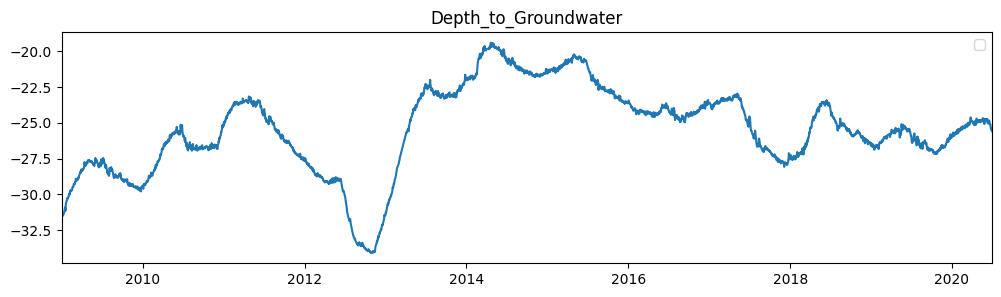

In [51]:
# Plot training and forecast
plt.figure(figsize=(12,3))
plt.plot(ts['Depth_to_Groundwater'])
plt.title('Depth_to_Groundwater')
plt.xlim(initial_date, final_date)
plt.legend()
plt.show()

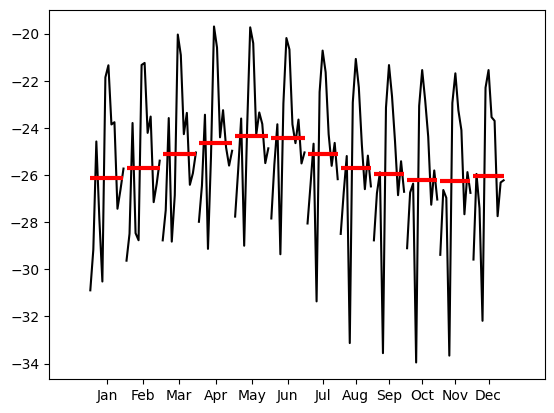

In [45]:
# Plotting the monthly seasonality
month_plot(ts['Depth_to_Groundwater'].resample('M').mean());

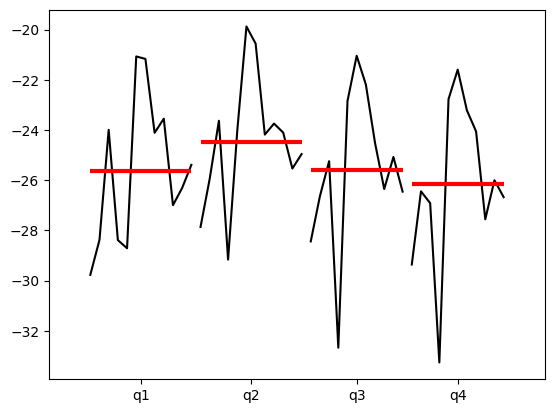

In [46]:
# Plotting the quarterly seasonality
quarter_plot(ts['Depth_to_Groundwater'].resample('Q').mean());

<function matplotlib.pyplot.show(close=None, block=None)>

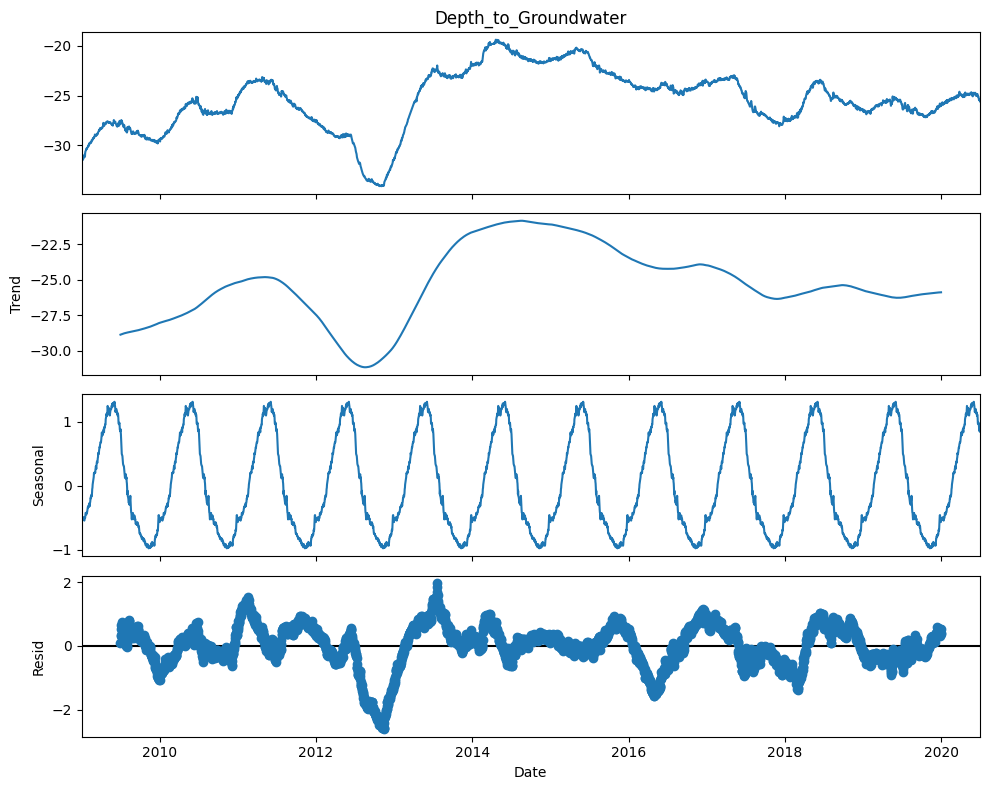

In [49]:
# Time Series Decomposition
decomposition = seasonal_decompose(ts['Depth_to_Groundwater'], model='add', period = 365) 
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.xlabel("Date")
plt.tight_layout()
plt.show

Autocorrelation analysis

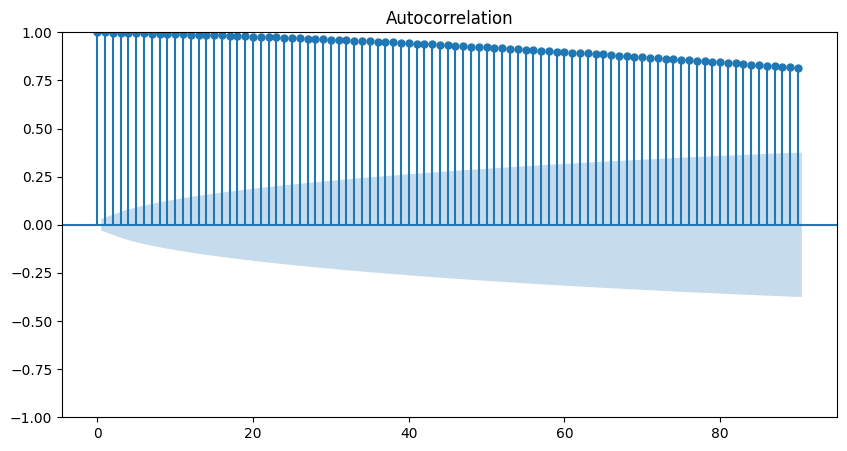

In [52]:
# Plotting the Auto-correlation (ACF)
fig, ax = plt.subplots(figsize = (10, 5))
plot_acf(ts['Depth_to_Groundwater'], lags = 90, ax = ax)
plt.show()

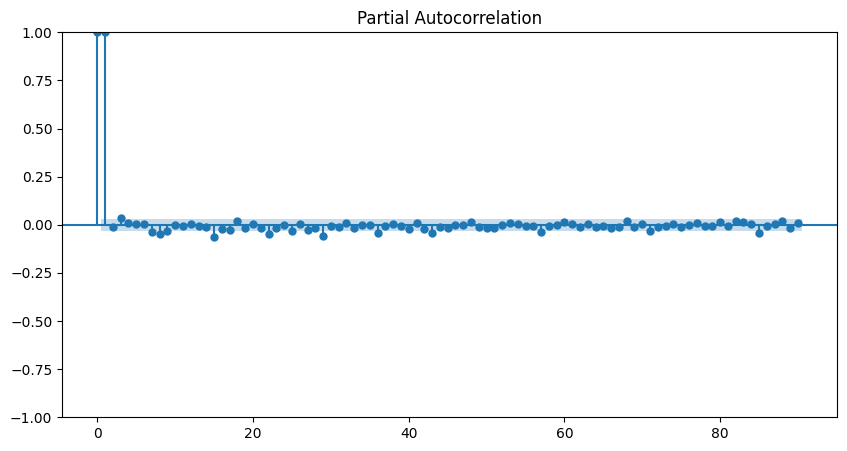

In [53]:
# Plot the Partial Auto-correlation (ACF)
fig, ax = plt.subplots(figsize = (10, 5))
plot_pacf(ts['Depth_to_Groundwater'], lags = 90, ax = ax)
plt.show()

### Step 4. Model training

In [62]:
# Training and Test Split
periods = 365
train, test = ts.iloc[:-periods, 0], ts.iloc[-periods:, 0]

In [67]:
# Holt - Winters Model
model = ExponentialSmoothing(train,
                             trend    = 'add',
                             seasonal = 'add',
                             seasonal_periods = 365).fit()
predictions = model.forecast(steps=len(test))

In [70]:
# Function to assess model and visualize output

def model_assessment(train, test, predictions, chart_title):
  
  # Plot training, test, and forecast
  plt.figure(figsize=(10,4))
  plt.plot(train, label = 'Training')
  plt.plot(test,  label = 'Test')
  plt.plot(predictions, label = 'Forecast')
  plt.title(f'Train, Test and Predictions with {chart_title}')
  plt.legend()
  plt.show()
  
  # Calculating the MAE, RMSE and MAPE
  mae = mean_absolute_error(test, predictions)
  print(f'Mean Absolute Error: {mae:.2f}')
  rmse = mean_squared_error(test, predictions)
  print(f'Root Mean Squared Error: {rmse:.2f}')
  mape = mean_absolute_percentage_error(test, predictions)
  print(f'Mean Absolute Percentage Error: {100*mape:.2f} %')

In [69]:
# Check for stationarity using Augmented Dickey-Fuller test
def check_stationary(time_series):
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test Results:')
    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1]<0.05

is_stationary = check_stationary(data_c['Depth_to_Groundwater'])
print(f"\nTime series is {'stationary' if is_stationary else 'non-stationary'}")


Augmented Dickey-Fuller Test Results:
ADF Statistic:  -2.6899831866780275
p-value:  0.07578771247522616
Critical values:
	1%: -3.4319378131425595
	5%: -2.8622416087789935
	10%: -2.5671434728538394

Time series is non-stationary


In [70]:
# Find and fit ARIMA model
auto_model = auto_arima(ts,
                        #start_p=0, start_q=0,
                        #max_p=5, maxq=5,
                        #m=7, #7-diariamente, 12-mensual, 52-semanal
                        seasonal=True,
                        #d=None,
                        trace=True,
                        #error_action='ignore',
                        #suppress_warnings=True,
                        #stepwise=True
                        )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7868.832, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7860.891, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7860.218, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7860.385, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7861.914, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7869.987, Time=2.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7871.311, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7870.174, Time=1.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7862.758, Time=1.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7868.171, Time=2.57 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7872.248, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7861.447, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7870.904, Time=1.30 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-7871.086, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0

In [35]:
model = ARIMA(ts, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
results = model.fit()

In [109]:
# Generate forecasts
period = 90
forecast_periods = period
forecast = results.get_forecast(steps=forecast_periods)
mean_forecast = forecast.predicted_mean

In [110]:
from datetime import timedelta

In [112]:
f_index = []
for i in range (0, period):
    date = final_date + timedelta(days = i)
    f_index.append(date)

mean_forecast.index = f_index


In [113]:
mean_forecast

2020-06-30   -25.582742
2020-07-01   -25.577090
2020-07-02   -25.577090
2020-07-03   -25.577090
2020-07-04   -25.577090
                ...    
2020-09-23   -25.577090
2020-09-24   -25.577090
2020-09-25   -25.577090
2020-09-26   -25.577090
2020-09-27   -25.577090
Name: predicted_mean, Length: 90, dtype: float64

<Axes: xlabel='Date'>

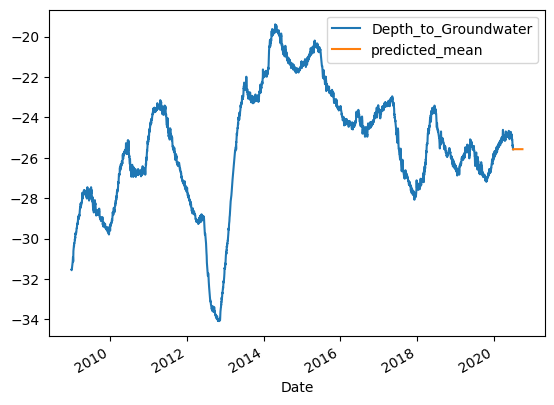

In [114]:
ts.plot(legend=True)
mean_forecast.plot(legend=True)

In [19]:
ts_stationary = data_c['Depth_to_Groundwater'].diff().dropna()

In [20]:
is_stationary = check_stationary(ts_stationary)
print(f"\nTime series is {'stationary' if is_stationary else 'non-stationary'}")

Augmented Dickey-Fuller Test Results:
ADF Statistic:  -6.2214936156182805
p-value:  5.2101068241844026e-08
Critical values:
	1%: -3.4319378131425595
	5%: -2.8622416087789935
	10%: -2.5671434728538394

Time series is stationary


In [22]:
auto_model = auto_arima(ts_stationary,
                        start_p=0, start_q=0,
                        max_p=5, maxq=5,
                        m=7, #7-diariamente, 12-mensual, 52-semanal
                        seasonal=True,
                        d=None,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True
                        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-8121.767, Time=3.05 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-7860.891, Time=0.35 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-7910.783, Time=2.44 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-7900.685, Time=1.67 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-7861.914, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-7902.523, Time=2.10 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-7912.757, Time=0.69 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=-8121.368, Time=8.04 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=-8121.347, Time=12.05 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=-7946.861, Time=4.32 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=-7971.815, Time=1.46 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=-8120.424, Time=8.40 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=-8120.077, Time=4.47 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=-8120.127, Time=5.37 sec
 ARIMA(1,0,1)(1,0,

In [27]:
model = ARIMA(ts_stationary,
              order=auto_model.order,
              seasonal_order=auto_model.seasonal_order
              )
results = model.fit()

In [28]:
forecast_periods = 7
forecast = results.get_forecast(steps=forecast_periods)
mean_forecast = forecast.predicted_mean

In [29]:
# Get confidence intervals
conf_int_95 = forecast.conf_int(alpha=0.05)
conf_int_80 = forecast.conf_int(alpha=0.20)
conf_int_70 = forecast.conf_int(alpha=0.30)

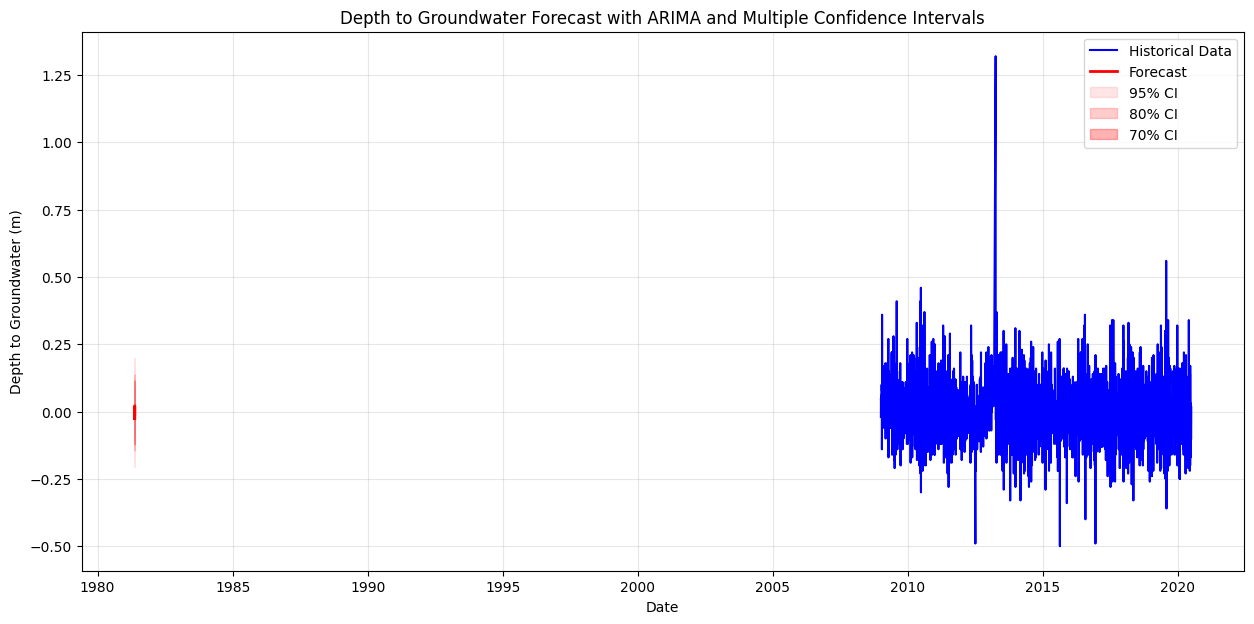

In [30]:
# Create visualization
plt.figure(figsize=(15, 7))

# Plot historical data and forecast
plt.plot(ts_stationary, label='Historical Data', color='blue')
plt.plot(mean_forecast, label='Forecast', color='red', linewidth=2)

# Plot confidence intervals
plt.fill_between(mean_forecast.index,
                 conf_int_95.iloc[:, 0],
                 conf_int_95.iloc[:, 1],
                 color='red', alpha=0.1,
                 label='95% CI')

plt.fill_between(mean_forecast.index,
                 conf_int_80.iloc[:, 0],
                 conf_int_80.iloc[:, 1],
                 color='red', alpha=0.2,
                 label='80% CI')

plt.fill_between(mean_forecast.index,
                 conf_int_70.iloc[:, 0],
                 conf_int_70.iloc[:, 1],
                 color='red', alpha=0.3,
                 label='70% CI')
                 
plt.title('Depth to Groundwater Forecast with ARIMA and Multiple Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Depth to Groundwater (m)')
plt.legend()
plt.grid(True, alpha=0.3)


### Step 3: Analysis of univariate variables

Analysis on numeric variables

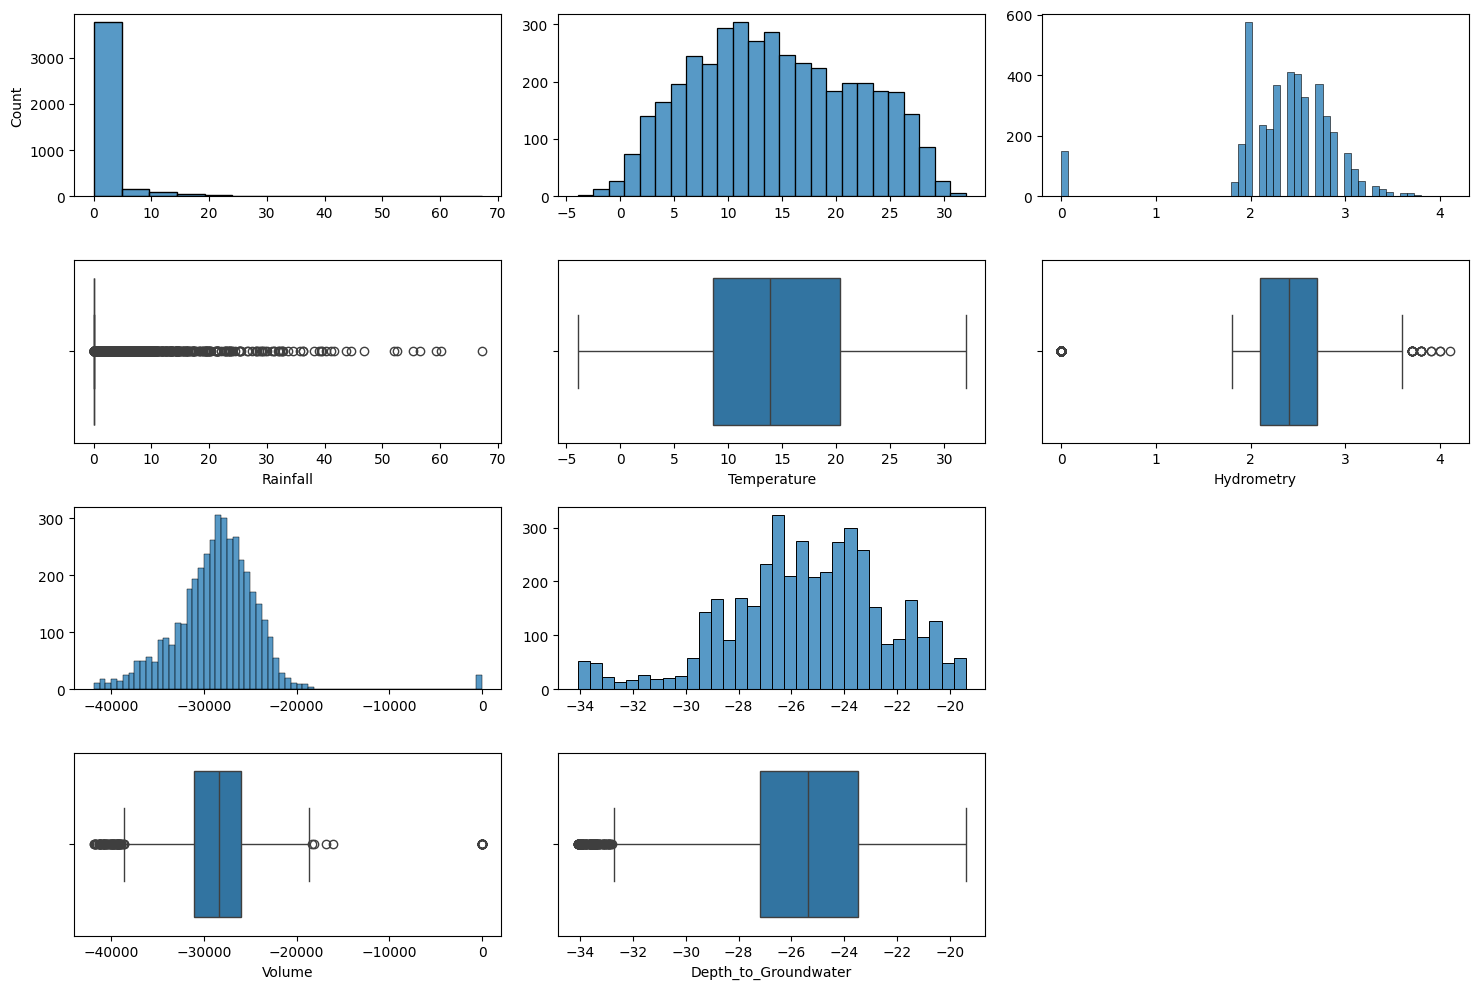

In [ ]:
fig, axis = plt.subplots(4, 3, figsize = (15, 10))

# Creating a multiple figure with histograms and box plots
sns.histplot(ax = axis[0, 0], data = data_c, x = "Rainfall").set(xlabel = None)
sns.boxplot (ax = axis[1, 0], data = data_c, x = "Rainfall")

sns.histplot(ax = axis[0, 1], data = data_c, x = "Temperature").set(xlabel = None, ylabel = None)
sns.boxplot (ax = axis[1, 1], data = data_c, x = "Temperature")

sns.histplot(ax = axis[0, 2], data = data_c, x = "Hydrometry").set(xlabel = None, ylabel = None)
sns.boxplot (ax = axis[1, 2], data = data_c, x = "Hydrometry")

sns.histplot(ax = axis[2, 0], data = data_c, x = "Volume").set(xlabel = None, ylabel = None)
sns.boxplot (ax = axis[3, 0], data = data_c, x = "Volume")

sns.histplot(ax = axis[2, 1], data = data_c, x = "Depth_to_Groundwater").set(xlabel = None, ylabel = None)
sns.boxplot (ax = axis[3, 1], data = data_c, x = "Depth_to_Groundwater")

# Adjust the layout
plt.tight_layout()

fig.delaxes(axis[2, 2])
fig.delaxes(axis[3, 2])

# Show the plot
plt.show()

### Step 4: Analysis of multivariate variables

<Axes: >

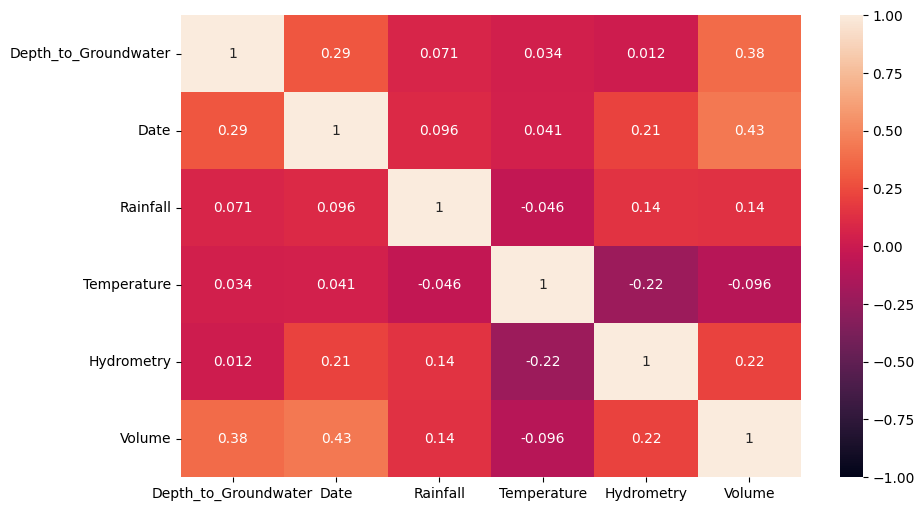

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(data_c[['Depth_to_Groundwater', 'Date', 'Rainfall',	'Temperature', 'Hydrometry', 'Volume']].corr().round(3),vmax=1,vmin=-1,annot=True)

In [ ]:
print("Looking at the heatmap, it is possible to see that the correlation between variables is very low")

Looking at the heatmap, it is possible to see that the correlation between variables is very low


In [ ]:
print("The features with the strongest relationship with Depth to Groundwater are Volume, Date and Rainfall.")

The features with the strongest relationship with Depth to Groundwater are Volume, Date and Rainfall.


### Step 5: Feature engineering

In [ ]:
data_c.describe()

,Date,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
count,4150,4150.000000,4150.000000,4150.000000,4150.000000,4150.000000
mean,2014-09-30 09:45:42.939759104,1.554723,14.397892,2.370265,-28647.225785,-25.451680
min,2009-01-01 00:00:00,0.000000,-3.950000,0.000000,-41890.176000,-34.090000
25%,2011-11-04 06:00:00,0.000000,8.600000,2.100000,-31065.768000,-27.180000
50%,2014-10-13 12:00:00,0.000000,13.900000,2.400000,-28375.056000,-25.355000
75%,2017-08-15 18:00:00,0.000000,20.350000,2.700000,-26028.864000,-23.480000
max,2020-06-30 00:00:00,67.300000,32.000000,4.100000,0.000000,-19.400000
std,NaN,5.232954,7.429788,0.591042,4573.361338,2.989767


In [ ]:
print("From previous analysis we can easily determine that the variable affected by outliers is Rainfall")

From previous analysis we can easily determine that the variable affected by outliers is Rainfall


### Step 6: Initialization and training of the model

Linear Model

In [ ]:
X = data_c[['Rainfall',	'Temperature', 'Hydrometry', 'Volume']]
Y = data_c[['Depth_to_Groundwater']]
X=sm.add_constant(X)

In [ ]:
model = sm.OLS(Y, X)
results = model.fit()

In [ ]:
predictions=results.predict(X)

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Depth_to_Groundwater   R-squared:                       0.153
Model:                              OLS   Adj. R-squared:                  0.153
Method:                   Least Squares   F-statistic:                     187.6
Date:                  Mon, 19 May 2025   Prob (F-statistic):          5.05e-148
Time:                          00:54:11   Log-Likelihood:                -10088.
No. Observations:                  4150   AIC:                         2.019e+04
Df Residuals:                      4145   BIC:                         2.022e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.6275      0.376    -46.923      0.000     -18.364     -16.891
Rainfall        0.0166      0.008      2.005      0.045       0.000       0.033
Temperature     0.0235      0.006      3.986      0.000       0.012       0.035
Hydrometry     -0.3307      0.076     -4.342      0.000      -0.480      -0.181
Volume          0.0003   9.64e-06     26.805      0.000       0.000       0.000
==============================================================================
Omnibus:                      111.579   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.853
Skew:                          -0.380   Prob(JB):                     1.28e-27
Kurtosis:                       3.371   Cond. No.                     2.57e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X = data_c.drop(columns=['Depth_to_Groundwater', 'Date'], axis = 1)
y = data_c['Depth_to_Groundwater']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
print(f"Intercep (a): {model_lr.intercept_}")
print(f"Coefficients (b1, b2, b3, b4): {model_lr.coef_}")

Intercep (a): -17.80061213164743
Coefficients (b1, b2, b3, b4): [ 2.08468469e-02  2.46855385e-02 -2.98138866e-01  2.56860044e-04]


In [ ]:
y_pred_lr = model_lr.predict(X_test)

In [ ]:
print(f"Mean squared error: {mean_squared_error(y_test, y_pred_lr)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred_lr)}")

Mean squared error: 7.928286729582988
Coefficient of determination: 0.13361202435717767


In [ ]:
metrics_list = []
model_lr = LinearRegression()
for _ in range(10_000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)
    model_lr.fit(X_train, y_train)
    y_pred_test = model_lr.predict(X_test)
    coefficient= r2_score(y_test, y_pred_test)
    metrics_list.append(coefficient)

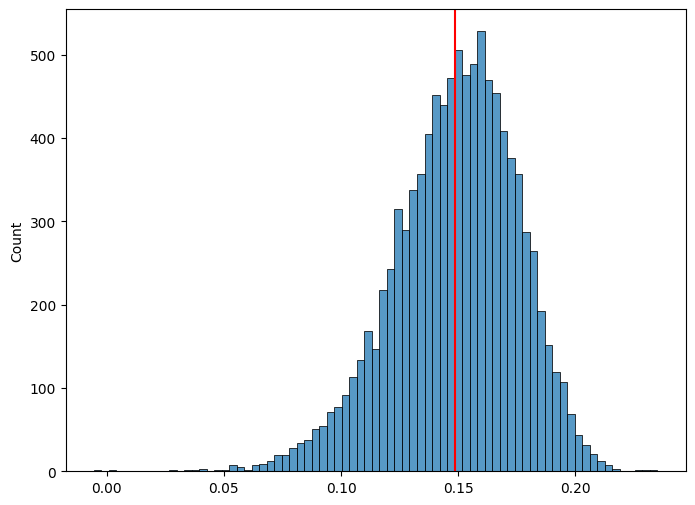

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(metrics_list)
plt.axvline(np.mean(metrics_list), color = 'red')

### Step 7: Analysis of a time series

Decomposition of the series

In [ ]:
initial_date=data_c['Date'].iloc[0]
initial_date

Timestamp('2009-01-01 00:00:00')

In [ ]:
final_date=data_c['Date'].iloc[len(data_c)-1]
final_date

Timestamp('2020-06-30 00:00:00')

In [ ]:
# Cambiar la columna 'ID' por el índice
ts_df = data_c.set_index('Date')
ts_df.head()

,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
Date,,,,,
2009-01-01,0.0,5.05,2.4,-24530.688,-31.55
2009-01-02,0.0,2.40,2.5,-28785.888,-31.57
2009-01-03,0.0,4.15,2.4,-25766.208,-31.52
2009-01-04,0.0,0.80,2.4,-27919.296,-31.48
2009-01-05,0.0,-2.00,2.3,-29854.656,-31.48


<function matplotlib.pyplot.show(close=None, block=None)>

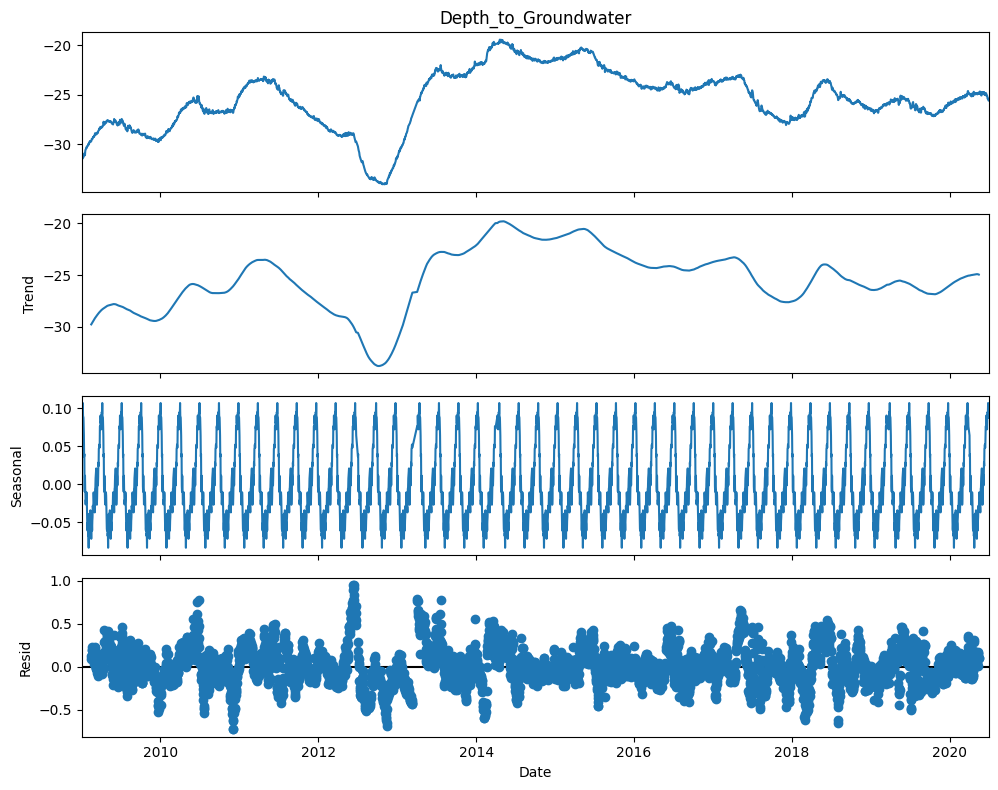

In [ ]:
decomposition = seasonal_decompose(ts_df['Depth_to_Groundwater'], model='additive', period=90) 
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.xlabel("Date")
plt.tight_layout()
plt.show

In [ ]:
adf_stat, p_value,*_ = adfuller(ts_df["Depth_to_Groundwater"])
print(f"p_value: {p_value}")

p_value: 0.07578771247522616


In [ ]:
print("Here we can see that the p-value is close to 0.05, which suggest that this series stationary.")

Here we can see that the p-value is close to 0.05, which suggest that this series stationary.


Autocorrelation analysis

<Figure size 640x480 with 0 Axes>

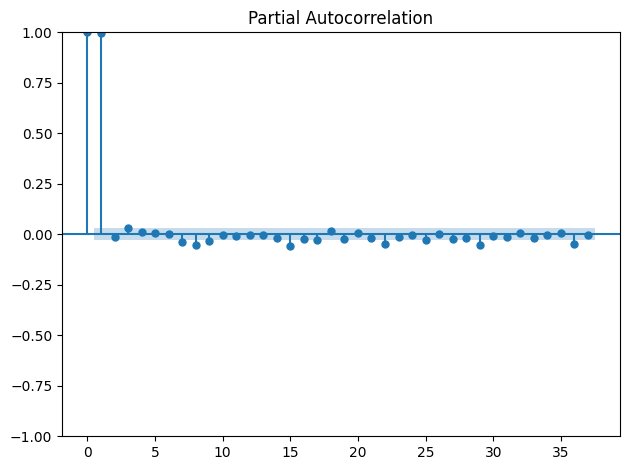

In [ ]:
plt.figure()
plot_pacf(ts_df["Depth_to_Groundwater"])
plt.tight_layout()
plt.show();

<Figure size 640x480 with 0 Axes>

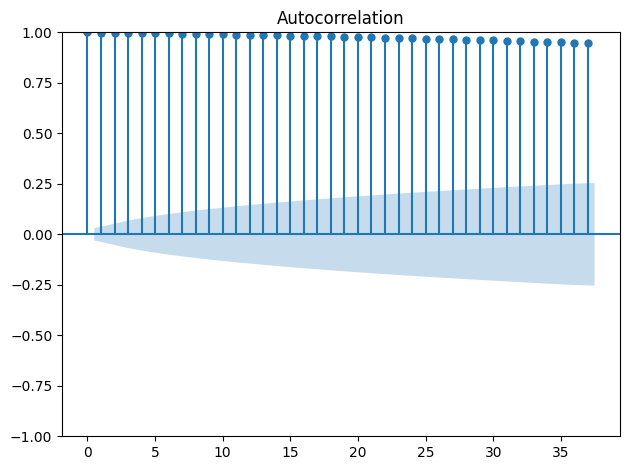

In [ ]:
plt.figure()
plot_acf(ts_df["Depth_to_Groundwater"])
plt.tight_layout()
plt.show();

In [ ]:
model= sm.tsa.AutoReg(ts_df["Depth_to_Groundwater"], lags=4).fit()

In [ ]:
print(model.summary())

                             AutoReg Model Results                              
Dep. Variable:     Depth_to_Groundwater   No. Observations:                 4150
Model:                       AutoReg(4)   Log Likelihood                3938.130
Method:                 Conditional MLE   S.D. of innovations              0.094
Date:                  Mon, 19 May 2025   AIC                          -7864.259
Time:                          00:55:27   BIC                          -7826.280
Sample:                               4   HQIC                         -7850.821
                                   4150                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0236      0.012     -1.891      0.059      -0.048       0.001
Depth_to_Groundwater.L1     1.0170      0.016     65.485      0.000       0.

Time Series Model Training

In [ ]:
from pmdarima import auto_arima

arima_model = auto_arima(data_c["Depth_to_Groundwater"], seasonal = False, trace = True, m = 7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7868.832, Time=5.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7860.891, Time=0.96 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7860.218, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7860.385, Time=2.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7861.914, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7869.987, Time=3.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7871.311, Time=2.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7870.174, Time=2.97 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7862.758, Time=2.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7868.171, Time=3.50 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7872.248, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7861.447, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-7870.904, Time=2.53 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-7871.086, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4150
Model:               SARIMAX(0, 1, 2)   Log Likelihood                3939.124
Date:                Mon, 19 May 2025   AIC                          -7872.248
Time:                        00:55:59   BIC                          -7853.256
Sample:                             0   HQIC                         -7865.528
                               - 4150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0182      0.014      1.329      0.184      -0.009       0.045
ma.L2         -0.0552      0.014     -3.851      0.000      -0.083      -0.027
sigma2         0.0088   7.48e-05    117.169      0.000       0.009       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22812.31
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model prediction

In [ ]:
forecast = arima_model.predict(365)

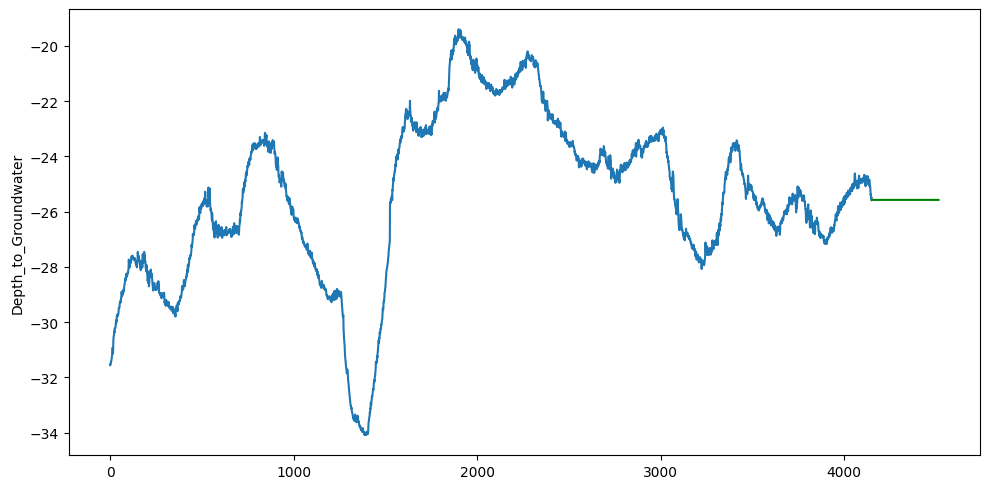

In [ ]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data_c["Depth_to_Groundwater"])
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()